In [2]:
import numpy as np
from numpy import pi as pi
import matplotlib.pyplot as plt
import qutip as q
import onix.models.hyperfine as hyperfine

%matplotlib ipympl

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.13s. Est. time left: 00:00:00:00
40.0%. Run time:   0.23s. Est. time left: 00:00:00:00
50.0%. Run time:   0.32s. Est. time left: 00:00:00:00
60.0%. Run time:   0.42s. Est. time left: 00:00:00:00
70.0%. Run time:   0.50s. Est. time left: 00:00:00:00
80.0%. Run time:   0.56s. Est. time left: 00:00:00:00
90.0%. Run time:   0.62s. Est. time left: 00:00:00:00
Total run time:   0.69s


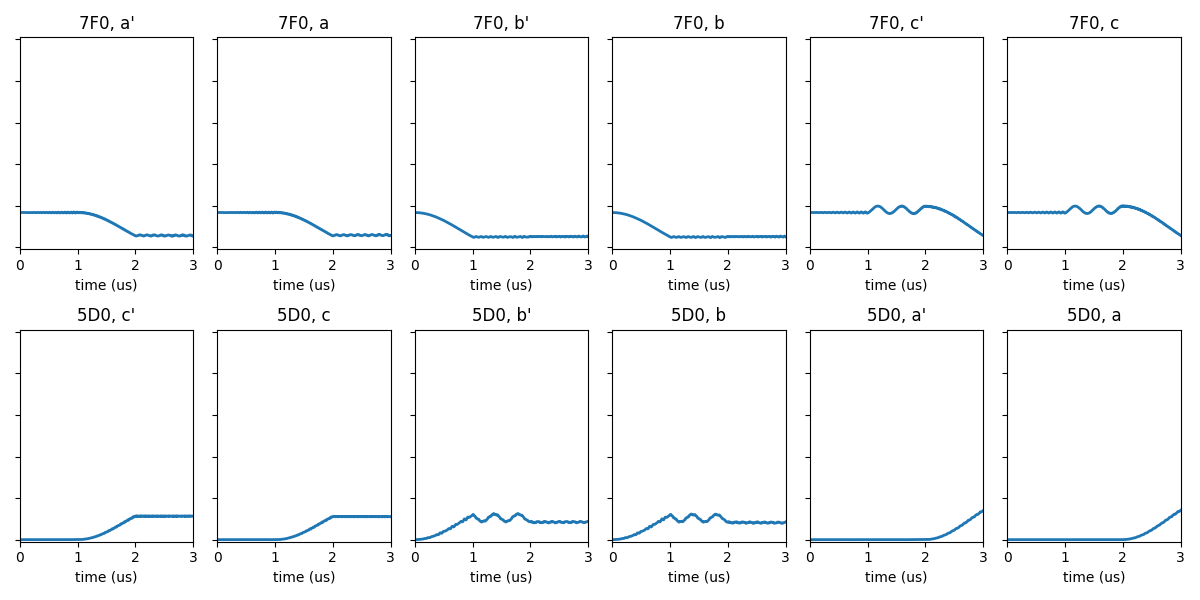

In [14]:
class Simulation:
    def __init__(
        self, 
        states_g: list = ["a", "a'", "b", "b'", "c", "c'"], 
        states_e: list = ["a", "a'", "b", "b'", "c", "c'"],
        B_field: float = 200e-4,
    ):
        # Compare list to fix input order for readability
        self._order_g = ["a'", "a", "b'", "b", "c'", "c"]
        self._order_e = ["c'", "c", "b'", "b", "a'", "a"]

        # Check input states
        for state in states_g + states_e:
            if state not in self._order_g:
                raise ValueError("Invalid input state.")

        # States
        self._states_g = states_g
        self._states_e = states_e

        # Static B field
        self.B_field = B_field
        
        # Total number of states
        self._N = len(set(states_g)) + len(set(states_e))

        # Basis
        self.basis = self._set_basis()

        # Energies
        self.energies = self._set_energies()
        
    def _set_basis(self):
        basis = {}
        c = 0
        for term, term_list, order_list in zip(["7F0", "5D0"], [self._states_g, self._states_e], [self._order_g, self._order_e]):
            if term_list:
                basis[term] = {}
            for state in order_list:
                if state in term_list:
                    basis[term][state] = q.basis(self._N, c)
                    c += 1
        return basis

    def _set_energies(self):        
        energies = {}
        for term, term_list, order_list in zip(["7F0", "5D0"], [self._states_g, self._states_e], [self._order_g, self._order_e]):
            if term_list:
                energies[term] = {}
                term_hyperfine = hyperfine.states[term]
                term_hyperfine._Hamiltonian = term_hyperfine.H_total(self.B_field)
                energies_list, _ = term_hyperfine.energies_and_eigenstates()
                for ss, state in enumerate(order_list):
                    if state in term_list:
                        energies[term][state] = energies_list[ss]
        return energies

    # set optical detuning for laser
    def _set_detuning(self, detuning):
        if self._states_e:
            for state, _ in self.energies["5D0"].items():
                self.energies["5D0"][state] += -detuning

    # diagonal energies
    def _get_H_0(self):
        return q.Qobj(np.diag([self.energies[term][state] for term, states in self.energies.items() for state, _ in states.items()]))

    # optical interaction RWA
    def _get_H_opt(self):
        Omega_opt = 1 # MHz
        H_opt = q.Qobj(np.zeros((self._N, self._N)))
        if self._states_e:
            for state_g in self.basis["7F0"]:
                for state_e in self.basis["5D0"]:
                    H_i = self.basis["7F0"][state_g] * self.basis["5D0"][state_e].dag() + self.basis["5D0"][state_e] * self.basis["7F0"][state_g].dag()
                    H_opt += Omega_opt/2 * H_i
        return H_opt

    # rf interaction
    def _get_H_rf(self, omega):
        N_g = len(set(self._states_g))
        H_rf = q.Qobj(np.zeros((self._N, self._N)))

        # RF Rabi frequency table
        # "state i/f" : "state f/i" : Rabi frequency in MHz
        rf_rabi_freqs = { 
            "a" : {
                "b" : 10e-3,
                "b'": 5e-3,
                "c" : 0,
                "c'": 0,
            },
            "a'": {
                "b" : 5e-3,
                "b'": 10e-3,
                "c" : 0,
                "c'": 0,
            },
            "b" : {
                "c" : 0,
                "c'": 0,
            },
            "b'": {
                "c" : 0,
                "c'": 0,   
            }
        }
        print 
        for state_1 in self.basis["7F0"]:
                for state_2 in self.basis["7F0"]:
                    if state_1 in rf_rabi_freqs.keys() and state_2 in rf_rabi_freqs[state_1].keys():
                        H_i = self.basis["7F0"][state_1] * self.basis["7F0"][state_2].dag() + self.basis["7F0"][state_2] * self.basis["7F0"][state_1].dag()
                        H_rf += rf_rabi_freqs[state_1][state_2] * H_i
        return H_rf

    # collapse operators as defined by qutip C = sqrt(gamma)*A where A is the jump operator
    def _get_c_ops(self, gamma):
        c_ops = []
        gammas = {
            # TODO: include unique gammas for each transition
        }
        if self._states_e:
            sum_basis_g = 0
            for state in self.basis["7F0"]:
                sum_basis_g += self.basis["7F0"][state]
            for state in self.basis["5D0"]:
                c_ops.append(np.sqrt(gamma) * sum_basis_g * self.basis["5D0"][state].dag())
        return c_ops

    def _get_rho0(self):
        N_g = len(set(self._states_g))
        sum_basis_g = 0
        for state in self.basis["7F0"]:
            sum_basis_g += self.basis["7F0"][state]
        return sum_basis_g / np.sqrt(N_g)
        
    def _rectangular_pulse(self, x, duration, start_time):
        start = start_time
        end = start_time + duration
        if x >= start and x < end:
            return 1
        else:
            return 0
        
    def _pulse(self, pulse_type, transition="", offset=0, duration=0, start_time=0):     
        if pulse_type == "optical":
            state_g = transition[0]
            state_e = transition[1]
        
            average_energy_g = (self.energies["7F0"][state_g] + self.energies["7F0"][state_g+"'"])/2
            average_energy_e = (self.energies["5D0"][state_e] + self.energies["5D0"][state_e+"'"])/2

            omega = abs(average_energy_e - average_energy_g)
            self._set_detuning(omega)
            H_0 = self._get_H_0()
            self._set_detuning(-omega)
            H_opt = self._get_H_opt()

            return [H_0 + H_opt, lambda t, args: self._rectangular_pulse(t, duration, start_time)]
            
        if pulse_type == "rf":
            omega = 119.2 + offset # MHz
            H_0 = self._get_H_0()
            H_rf = self._get_H_rf(omega)
            
            return [[H_0, lambda t, args: self._rectangular_pulse(t, duration, start_time)], [H_rf, lambda t, args: np.sin(omega * t) * self._rectangular_pulse(t, duration, start_time)]]   

    def run_sequence(self):
        sequence = self.set_sequence()
        H_total = []
        total_time = 0

        for seq in sequence:
            if seq[0] == "optical":
                H_total.append(self._pulse(seq[0], transition = seq[1], duration = seq[2], start_time = total_time))
                total_time += seq[2]
                
            if seq[0] == "rf":
                H_0, H_rf = self._pulse(seq[0], offset = seq[1], duration = seq[2], start_time = total_time)
                H_total.append(H_0)
                H_total.append(H_rf)
                total_time += seq[2]
                
            if seq[0] == "delay":
                total_time += seq[1]
        
        return H_total, total_time

    def set_sequence(self):
        sequence = []

        # OPTICAL PULSES ("optical"  , transition     , duration (us))
        # RF PULSES      ("rf"       , offset (MHz)   , duration (us))
        # DELAY          ("delay"    , duration (us)                 )
        
        sequence.append(("optical", "bb", 1))
        sequence.append(("optical", "ac", 1))
        sequence.append(("optical", "ca", 1))
        # sequence.append(("delay", 50))
        # sequence.append(("rf", -0.2, 300))
        # sequence.append(("delay", 50))
        # sequence.append(("rf", 0.1, 300))

        return sequence
        
    def plot_simulation(self):
        # TODO: plots for any input state config
        fig, axs = plt.subplots(2, 6, figsize=(12, 6))
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                axs[ii, jj].plot(self.ts, self.results.expect[ii*6+jj], label = f"{i}, {j}", linewidth=2)
                axs[ii, jj].set_title(f"{i}, {j}")
                axs[ii, jj].set_ylim([-1e-2, 1+1e-2])
                axs[ii, jj].set_xlim([0, np.max(self.ts)])
                axs[ii, jj].set_yticklabels([])
                axs[ii, jj].set_xlabel("time (us)")

        plt.tight_layout()
        plt.show()

    def single_plot_simulation(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                ax.plot(self.ts, self.results.expect[ii*6+jj], label = f"{i}, {j}", linewidth=2)
                ax.set_ylim([-1e-2, 1+1e-2])
                ax.set_xlim([0, np.max(self.ts)])
                ax.set_xlabel("time (us)")
                ax.set_ylabel("population")

        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def run_simulation(self, iters: int = 1000):
        H_total, total_time = self.run_sequence()
        ts = np.linspace(0, total_time, iters)

        # TODO: fix to have any input state config
        c_ops = self._get_c_ops(2e-4)
        rho_0 = self._get_rho0()
        e_ops = [self.basis[i][j] * self.basis[i][j].dag() for i, iv in self.basis.items() for j, _ in iv.items()]
        opts = q.Options(nsteps = 100000)
        
        self.results = q.mesolve(H_total, rho_0, ts, c_ops = c_ops, e_ops = e_ops, progress_bar = True, options = opts)
        self.ts = ts
        
        
simulation = Simulation()
simulation.run_simulation()
simulation.plot_simulation()

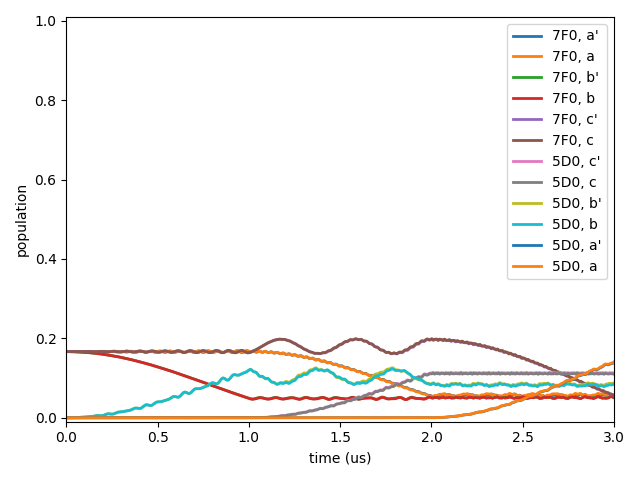

In [15]:
simulation.single_plot_simulation()